# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and Tensorflow Hub.

## 1. Problem

Identifying the breed of a dog given an image of the dog.

## 2. Data

The data we're using is from Kaggle: https://www.kaggle.com/c/dog-breed-identification

## 3. Evaluation

The evaluation is a file with prediciton probabilities for each dog breed of each test image. See data URL.

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's best that we use deep learning/transfer learning.
* There are 120 breeds of dogs
* There are around 10,000 + images in the training set (these images have labels)
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them.)

### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [1]:
# import tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print('TF Hub version: ', hub.__version__)

# Check for GPU availability
print(tf.config.list_physical_devices())

2024-06-25 16:58:25.851948: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 16:58:26.024511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 16:58:26.024542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 16:58:26.055948: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-25 16:58:26.121168: I tensorflow/core/platform/cpu_feature_guar

TF version:  2.15.1
TF Hub version:  0.16.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-25 16:58:28.780691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 16:58:28.820306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 16:58:28.820335: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Getting our data read (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numberical representations).

Let's start by accessing our data and checking our labels.

In [2]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv('/dogvision/dog-breed-identification/labels.csv')
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

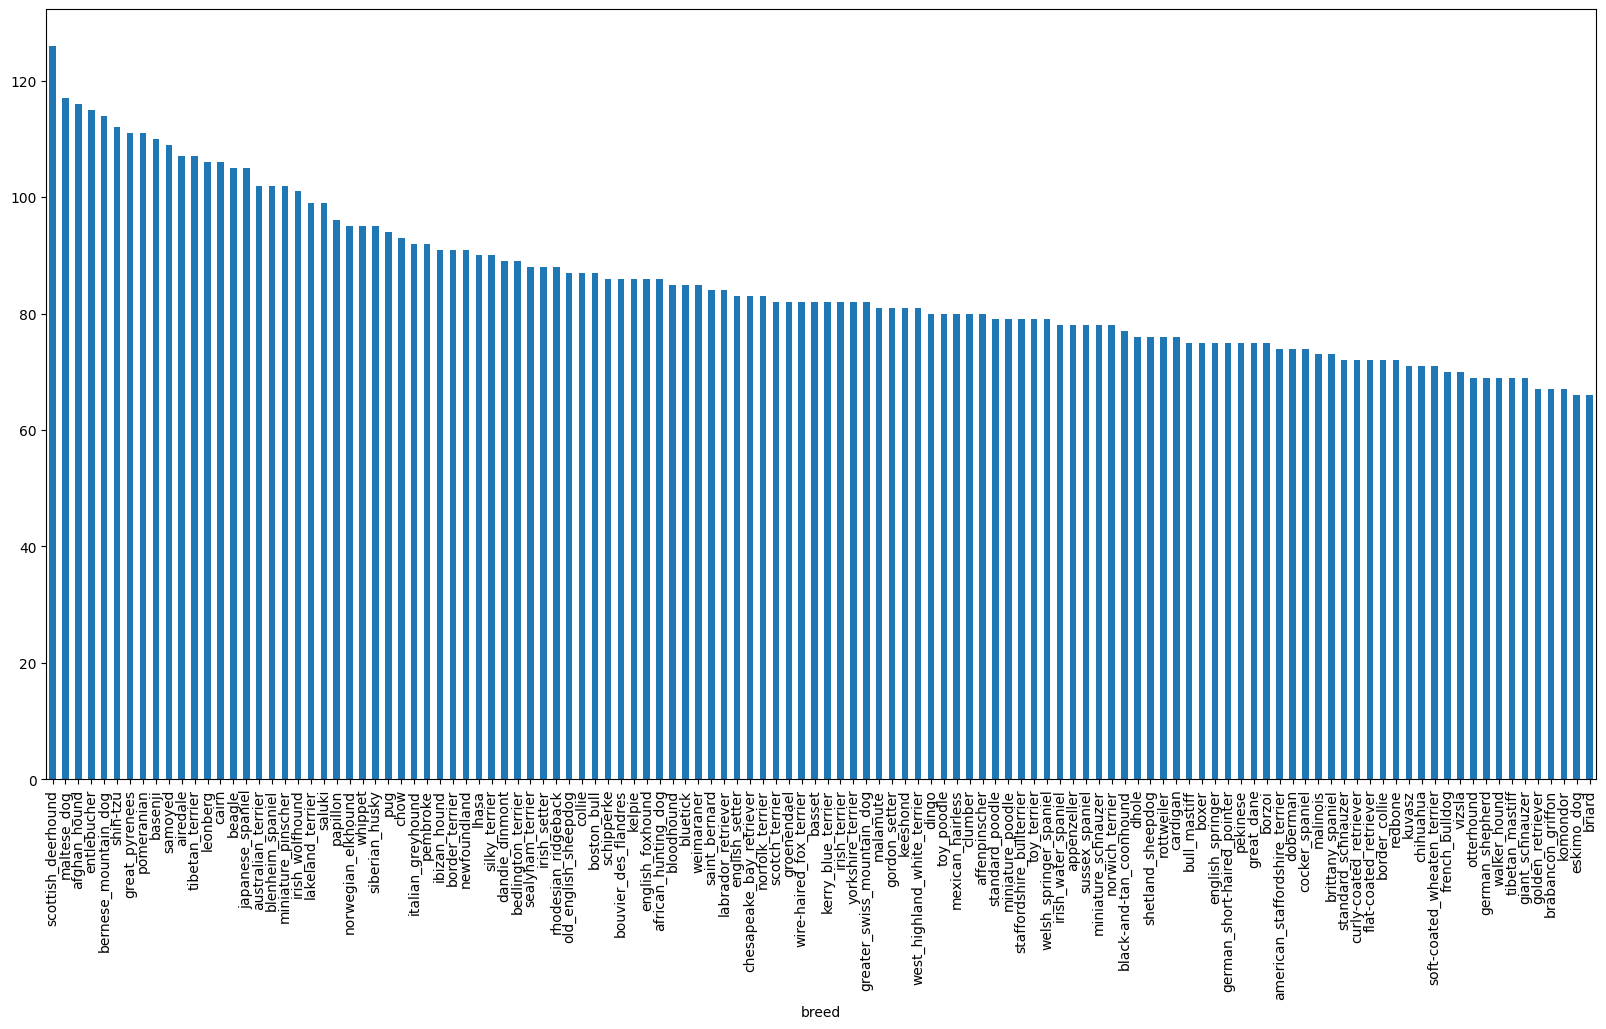

In [3]:
# How many images are there of each breed
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10))

In [4]:
labels_csv['breed'].value_counts().median()

82.0

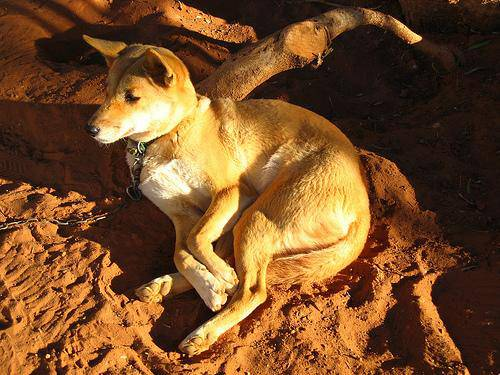

In [5]:
# Let's view an image
from IPython.display import Image
Image('/dogvision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

### Getting images and their labels

Let's get a list of all of our image file pathnames

In [6]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [7]:
# Create pathnames from image ID's
filenames = ['/dogvision/dog-breed-identification/train/' + fname + '.jpg' for fname in labels_csv['id']]

# Check the first 10
filenames[:10]

['/dogvision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/dogvision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/dogvision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/dogvision/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/dogvision/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/dogvision/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/dogvision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/dogvision/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/dogvision/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/dogvision/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [8]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir('/dogvision/dog-breed-identification/train')) == len(filenames):
  print('Number of labels matches number of photos. Good to go!')
else:
  print('Number of labels do not match number of images')

Number of labels matches number of photos. Good to go!


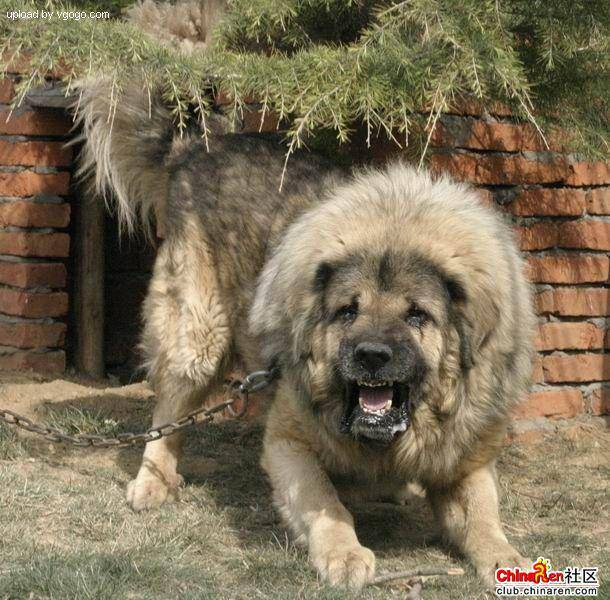

In [9]:
# One more check
Image(filenames[9000])

In [10]:
labels_csv['breed'][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [11]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:
len(labels)

10222

In [13]:
# See if number of labels matches number of filenames
if len(labels) == len(filenames):
  print('Number of labels matches number of filenames.')
else:
  print('Number of labels dows not match number of filnames. Check your data.')


Number of labels matches number of filenames.


In [14]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [15]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:3]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [17]:
len(boolean_labels)

10222

In [18]:
# Example: Turning boolean array into integers
print(labels[0]) # origninal label
print(np.where(unique_breeds == labels[0])) # indes where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [19]:
# Setup X and y variables
X = filenames
y = boolean_labels

In [20]:
len(filenames)

10222

We're going to start off experimenting with ~1000 images and increase as needed to save time.

In [21]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 # @param {type:'slider', min:1000, max:10000, step:1000}

In [22]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [23]:
# Let's have a look at the training data
X_train[:2], y_train[:2]

(['/dogvision/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/dogvision/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, Fa

## Preprocessing Images (turning images into Tensors)

To preporcess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

Before we do, let's ee what importing an image looks like.

In [24]:
# Convert an image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [25]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [26]:
# Turn image into a tensor
tf.constant(image)[:2]

2024-06-25 16:58:31.561105: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 16:58:31.561149: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 16:58:31.561158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 16:58:31.709058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 16:58:31.709085: I external/local_xla/xla/stream_executor

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize image (convert color channel values from 0-255 to 0-1.
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`



In [27]:
# Defien image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes and image file path and turns the image into a tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpg image into numberical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're tryingto process 10,000+ images in one go... they all might not fit in memory.

So that's why we do about 32 (batch size) images at a time (you can manually change the batch size if needed.

In order to use TensorFlow effectively, we need our data int he form of Tensor tuples which look like this:
`(image, label)`.

In [28]:
# Create a simple function to retrun a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [29]:
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches.

In [128]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print('Create test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(batch_size=batch_size)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # X: filepaths, y: labels
    data_batch = data.map(get_image_label).batch(batch_size=batch_size)
    return data_batch

  else:
    print('Creating training data batches...')
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turn the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(batch_size=batch_size)
  return data_batch


In [129]:

# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)


Creating training data batches...
Creating validation data batches...


In [32]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is not in batches, however, these can e a little hard to understand/comprehend, lets visualize them.

In [33]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
#
# DOES NOT WORK
#
def show_25_images(images, labels):
  """
  Displays a plot of 25 images nad their labels from a data batch.
  """

  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i + 1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis('off')
    
  # Fix spacing
  plt.tight_layout()

In [34]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

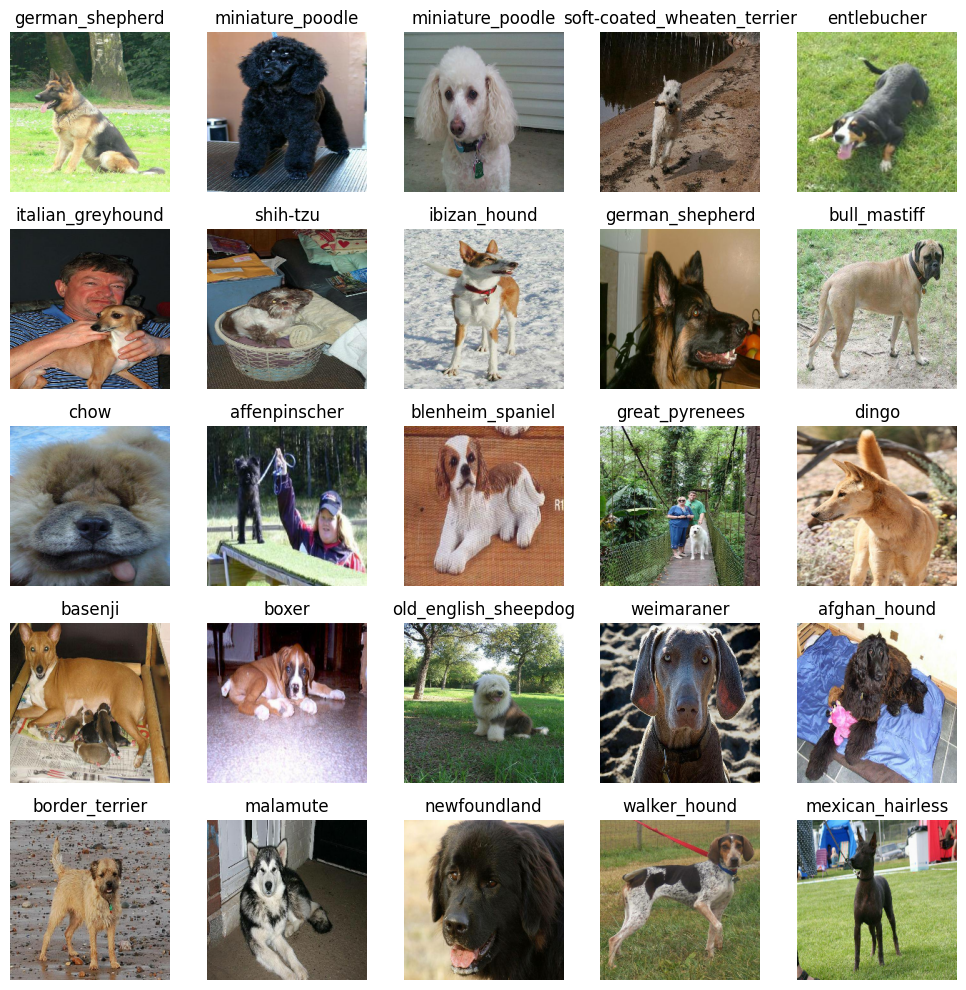

In [35]:
# Now let's visualize the data ina  training batch
show_25_images(train_images, train_labels)

## Building a model

Before we builda model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The ouput shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from Kaggle/TensorFlow Hub: "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2"

In [36]:
IMG_SIZE

224

In [37]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2"

Now we've gout our inputs, outputs and model ready to go. Let's put them together into a keras deep learning model.

Knowing this, let's create a function which:
* Takes the input shape, output shape an dthe model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tell the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [38]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print('Building model with: ', MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL), # Layer 1 (input layer),
                                              tf.keras.layers.Dense(units=OUTPUT_SHAPE, # Layer 2 (output layer)
                                              activation='softmax')])
  
  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [39]:
model = create_model()
model.summary()

Building model with:  https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our model's progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Viusalize our model's training logs with the `%tensorboard` magic function (we'll do this after model training).


In [40]:
# Load TensorBoard notebook extension
%load_ext tensorboard


In [41]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join('/dogvision/dog-breed-identification/logs',
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


In [42]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

## Training a model (on a subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [43]:
NUM_EPOCHS = 100 # @param {type:'slider', min:10, max:100, step:10}


In [44]:
# Check to make sure we're still runningon a GPU
print('GPU', 'available' if tf.config.list_physical_devices('GPU') else 'not available')

GPU available


Let's create a function that trains a model

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epocks to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [45]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and retuns the trained version.
  """

  # Create a model
  model = create_model()

  # Create a new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [46]:
# Fit the model to the data
model = train_model()

Building model with:  https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Epoch 1/100


2024-06-25 16:58:39.562093: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-06-25 16:58:40.299743: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcde1076920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-25 16:58:40.299767: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-25 16:58:40.307150: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719334720.370952     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 4s 61ms/step - loss: 4.5447 - accuracy: 0.1013 - val_loss: 3.4849 - val_accuracy: 0.2650
Epoch 2/100
25/25 [==============================] - 1s 46ms/step - loss: 1.6465 - accuracy: 0.6900 - val_loss: 2.2603 - val_accuracy: 0.4900
Epoch 3/100
25/25 [==============================] - 1s 47ms/step - loss: 0.5874 - accuracy: 0.9250 - val_loss: 1.7859 - val_accuracy: 0.6000
Epoch 4/100
25/25 [==============================] - 1s 46ms/step - loss: 0.2639 - accuracy: 0.9837 - val_loss: 1.5867 - val_accuracy: 0.6300
Epoch 5/100
25/25 [==============================] - 1s 46ms/step - loss: 0.1518 - accuracy: 0.9975 - val_loss: 1.5133 - val_accuracy: 0.6150
Epoch 6/100
25/25 [==============================] - 1s 45ms/step - loss: 0.1041 - accuracy: 0.9987 - val_loss: 1.4657 - val_accuracy: 0.6350
Epoch 7/100
25/25 [==============================] - 1s 47ms/step - loss: 0.0770 - accuracy: 1.0000 - val_loss: 1.4354 - val_accuracy: 0.6350
Epoch 8/100
25/25 

Model is overfitting. How do we prevent this?

**Note:** Overfitting is a good thing at first. It means the model is learning. 

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize the contents. 

In [47]:
# Does not work, probably related to docker container
# %tensorboard --logdir /dog-breed-identification/logs --host 0.0.0.0

## Making and evaluating predictions using a trained model

In [48]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [49]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 33ms/step


array([[8.92942888e-04, 1.77620081e-04, 3.30265553e-04, ...,
        1.06854108e-03, 2.64212194e-05, 2.18722527e-03],
       [2.06613494e-03, 3.10383417e-04, 4.95722704e-02, ...,
        2.58717744e-04, 4.73931292e-03, 4.18630370e-04],
       [8.35916217e-05, 4.47954400e-04, 8.32687016e-04, ...,
        8.07841498e-05, 1.00030993e-04, 5.75793209e-03],
       ...,
       [3.60013269e-06, 1.20211744e-05, 2.03802156e-05, ...,
        1.13731621e-05, 2.96459166e-05, 2.87670100e-05],
       [4.47751814e-03, 3.75109346e-04, 1.86487130e-04, ...,
        2.05182703e-04, 1.55996706e-04, 1.10259131e-02],
       [2.02082866e-03, 1.15095696e-04, 7.08518270e-03, ...,
        4.05716524e-03, 1.30530202e-03, 1.54089546e-04]], dtype=float32)

In [50]:
np.sum(predictions[0])

0.99999994

In [51]:
# First prediction
index = 0
print(predictions[index])
print(f'Max value (probability of prediction): {np.max(predictions[index])}')
print(f'Sum: {np.sum(predictions[index])}')
print(f'Max index: {np.argmax(predictions[index])}')
print(f'Predicted label: {unique_breeds[np.argmax(predictions[index])]}')

type(predictions)

[8.92942888e-04 1.77620081e-04 3.30265553e-04 1.21498430e-04
 3.05294700e-04 1.16596333e-04 7.30329975e-02 3.12849326e-04
 4.36479488e-04 5.70145028e-04 3.05621274e-04 5.38978667e-04
 8.15292471e-04 8.85116824e-05 1.73838239e-03 9.87284118e-04
 1.77983442e-04 6.84271529e-02 8.99241968e-06 8.26553805e-05
 1.43630977e-03 3.09665309e-04 3.37488709e-05 1.45427627e-03
 7.12770416e-05 2.27102009e-03 1.29085869e-01 3.29252616e-05
 1.63168297e-04 1.36404927e-03 1.29054228e-04 6.04091620e-04
 4.22084064e-04 1.89840212e-04 1.05050203e-04 3.01221069e-02
 8.35190294e-05 1.05591945e-03 7.40063479e-05 1.69424835e-04
 1.63796393e-03 1.36592562e-05 1.42072007e-04 1.19169468e-04
 5.11658509e-05 3.94714443e-04 1.79995259e-04 9.39128164e-04
 2.85521470e-04 6.23608532e-04 2.19611349e-04 1.25678038e-04
 8.05360673e-04 8.04792944e-05 4.97358596e-05 8.20526766e-05
 6.18119549e-04 2.24925438e-03 4.47865285e-04 3.85383144e-02
 6.76108059e-04 6.81660676e-05 5.77304512e-03 1.15198600e-04
 4.26894927e-04 4.054565

numpy.ndarray

Having the above functionality is great but we want to be able to do it at scale. 

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels. 

In [52]:
# Turn probabilities into their respective labels 
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label. 

    Args:
        prediction_probabilities (numpy.ndarray): Array of probabilities
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [53]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [63]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and return separate arrays of images and labels. 

    Args:
        data (BatchDataset): Batched dataset of images and labels
    """
    images = []
    labels = []

    # Loop through unbatched data 
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels
# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [55]:
get_pred_label(val_labels[0])

'cairn'

In [56]:
images_ = []
labels_ = []

# Loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label)
images_[0], labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [57]:
get_pred_label(labels_[0])

'cairn'

In [58]:
get_pred_label(predictions[0])

'lhasa'

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visualized.

We'll create a function which:
* Takes an array of prediction probabilities, and array of truth labels, and an array of images and integers.
* Convert the prediction probabilities to a predicted label. 
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [66]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth and image for sample n

    Args:
        prediction_probabilities (numpy.ndarray): The confidence values of each label.
        labels (_type_): _description_
        images (_type_): _description_
        n (int, optional): _description_. Defaults to 1.
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
    
    # Get the pred label
    pred_label = get_pred_label(pred_prob)
    
    # Plot image and remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    # Change plot title to be predicted, probability of prediction and truth label
    plt.title('{} {:2.0f}% {}'.format(pred_label, np.max(pred_prob)*100, true_label), color=color)

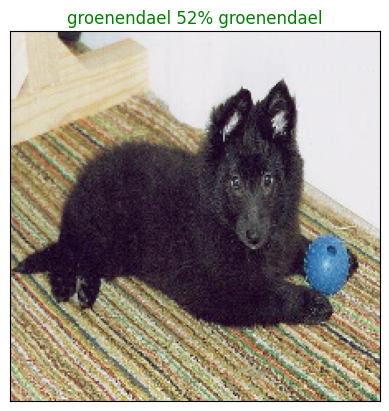

In [70]:
plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images, n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our model's top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer.
* Find the prediction using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green

In [104]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plus the top 10 highest prediction confidences along with the truth label for sample n.
    """
    pred_prob, true_label = prediction_probabilities[n], labels[n]
    
    # Get the predicted label
    pred_label = get_pred_label(pred_prob)
    
    # Find te top 10 prediction confidence indexes
    top_10_pred_indexes = predictions[n].argsort()[::-1][:10]
    
    # Find the top 10 prediction confidence values
    top_10_pred_values = predictions[n][predictions[n].argsort()[::-1][:10]]
    
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]
    
    # Setup plot 
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), top_10_pred_values, color='grey')
    
    plt.xticks(np.arange(len(top_10_pred_labels)), labels=top_10_pred_labels, rotation='vertical')
    
    # Change the color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
        
    

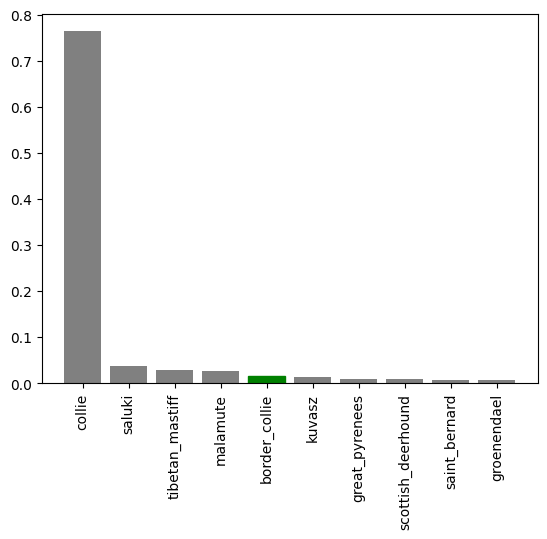

In [107]:
plot_pred_conf(prediction_probabilities=predictions, labels=val_labels, n=9)

Now we've got some functions to help us visualize our predictions and evaluate our model, let's check out a few.

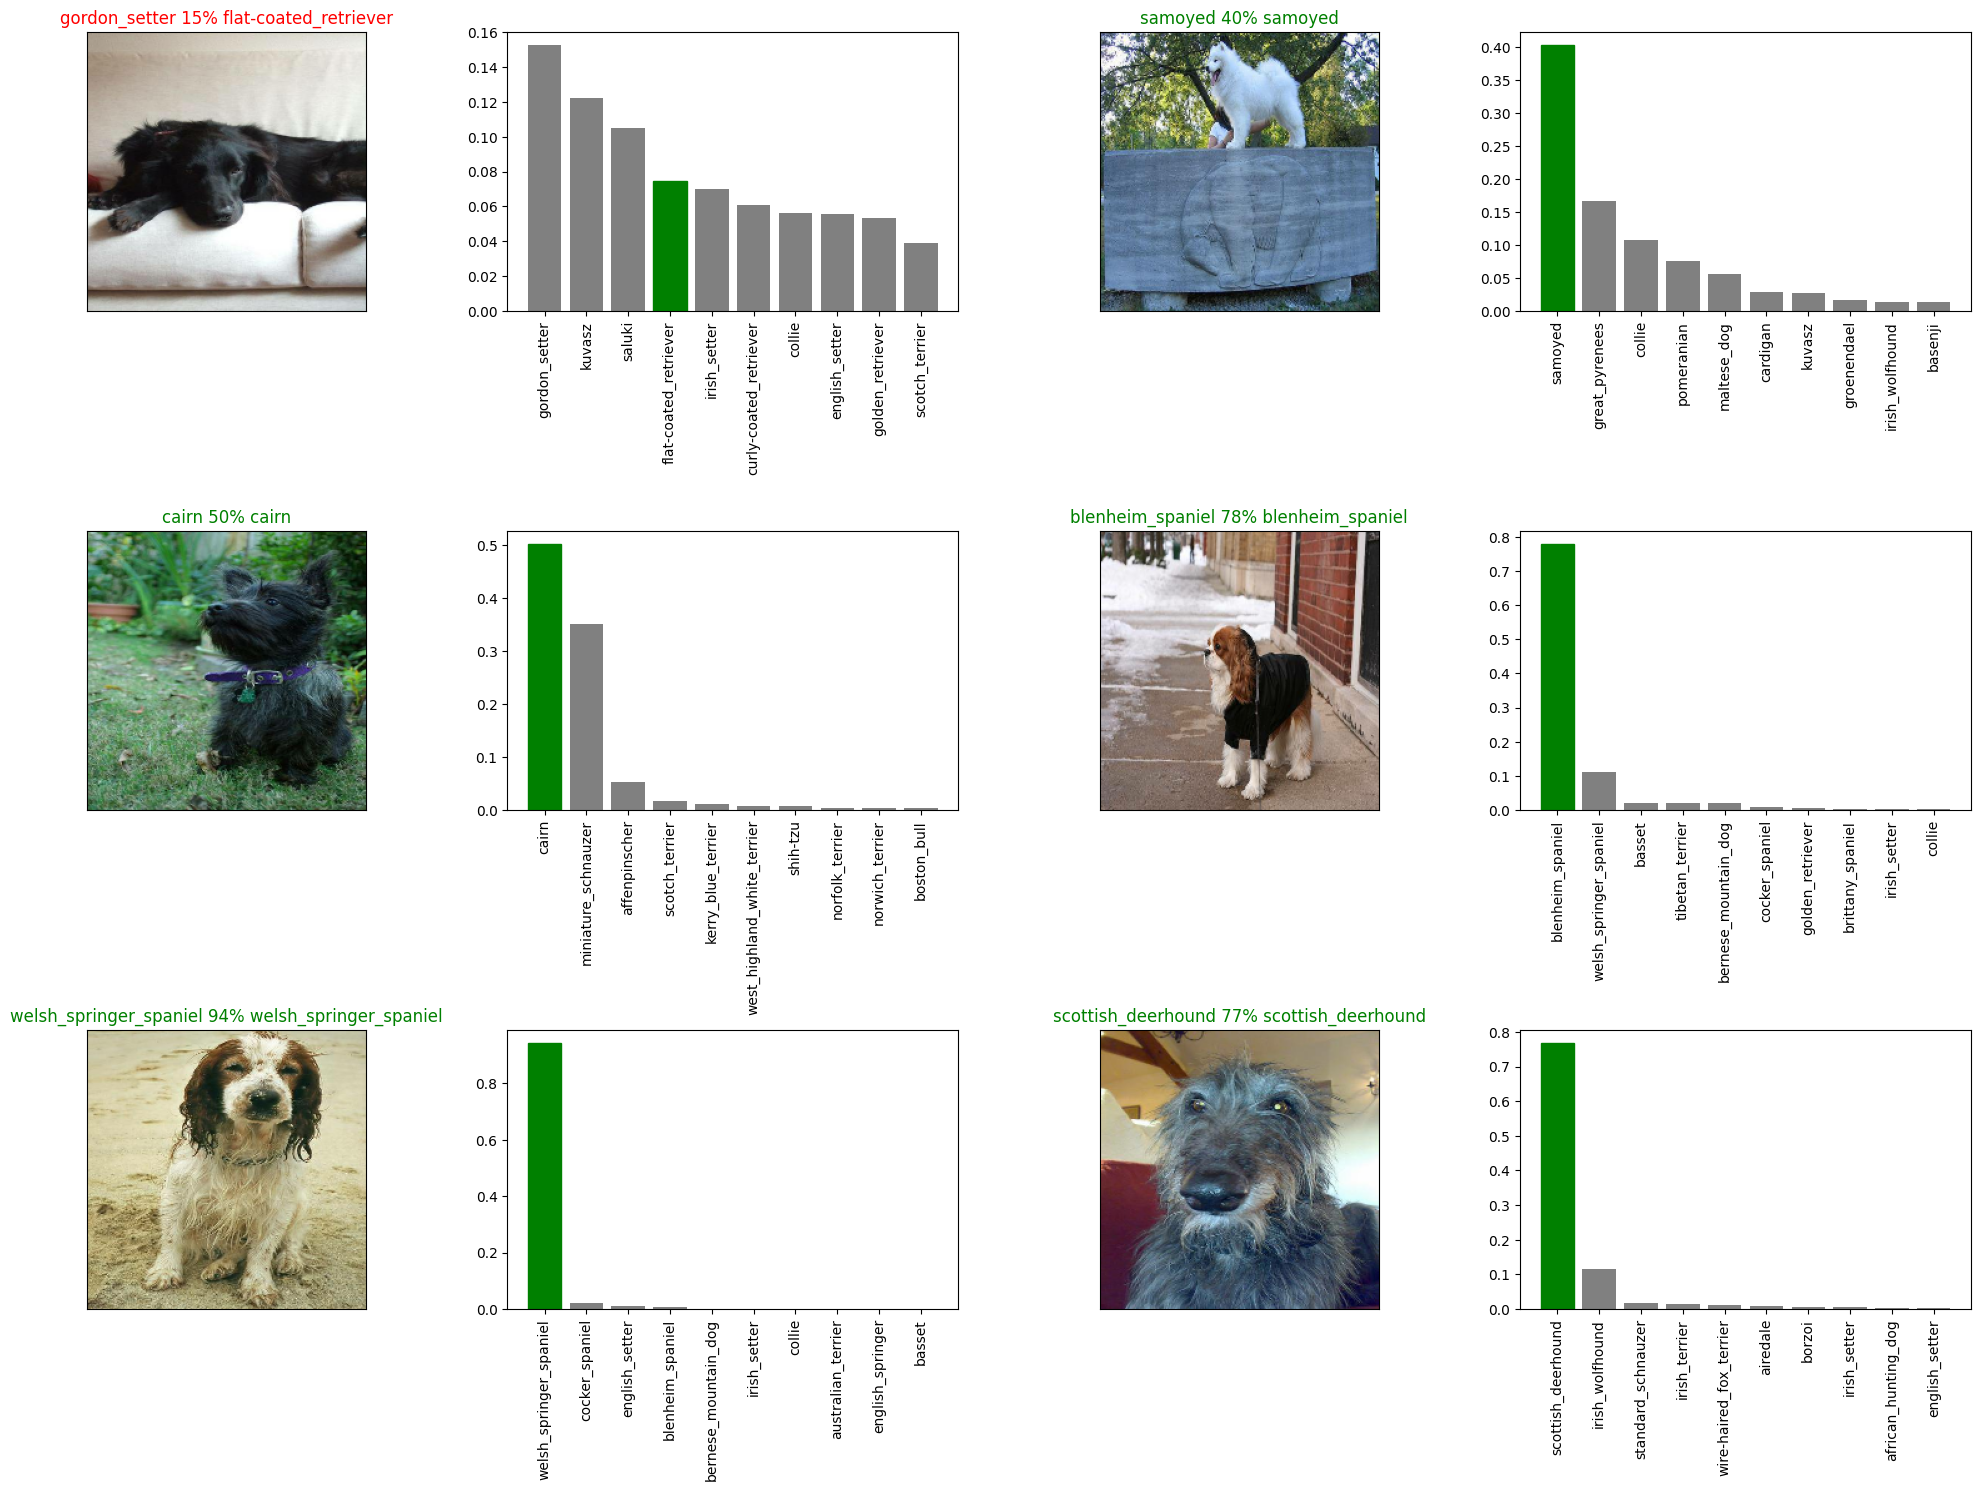

In [111]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images, n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=predictions, labels=val_labels, n=i+i_multiplier)
plt.tight_layout()

## Saving and reloading a trained model

In [112]:
# Create a function to save a model
def save_model(model, suffix=None):
    """
    Save a given model in a models directory and appends a suffix (string)
    """
    
    # Create a model directory pathname with current time
    modeldir = os.path.join('/dogvision/models', datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
    model_path = modeldir + '-' + suffix + '.h5' # Save format of model
    print(f'Saving model to: {model_path}...')
    model.save(model_path)
    return model_path
    
    

In [114]:
# Create a function ot load a trained model 
def load_model(model_path):
    """
    Loads a saved model from a specified path
    """
    print(f'Loading saved model from: {model_path}')
    model = tf.keras.models.load_model(model_path, custom_objects={'KerasLayer': hub.KerasLayer})
    return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [115]:
# Save our model trained on 1000 images
save_model(model, suffix='100-images-mobilenetv2-Adam')

Saving model to: /dogvision/models/20240625-18201719339621-100-images-mobilenetv2-Adam.h5...


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/dogvision/models/20240625-18201719339621-100-images-mobilenetv2-Adam.h5'

In [117]:
loaded_model = load_model('/dogvision/models/20240625-18201719339621-100-images-mobilenetv2-Adam.h5')

Loading saved model from: /dogvision/models/20240625-18201719339621-100-images-mobilenetv2-Adam.h5


In [119]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 0s 31ms/step - loss: 1.3565 - accuracy: 0.6500


[1.3565326929092407, 0.6499999761581421]

In [121]:
# Evaluate the loaded model
loaded_model.evaluate(val_data)

7/7 [==============================] - 0s 31ms/step - loss: 1.3565 - accuracy: 0.6500


[1.3565326929092407, 0.6499999761581421]

## Training a big dog model on the full data

In [122]:
len(X), len(y)

(10222, 10222)

In [130]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [131]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [132]:
# Create a model for full model
full_model = create_model()

Building model with:  https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2


In [133]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

**Note:** Running the cell below will take a little while in colab (maybe up to 30 minute for the first epoch) because of the large number of images that must be loaded into the GPU memory. 
It is considerably faster on local GPU.

In [134]:
# Fit the full model to the full data
full_model.fit(x=full_data, epochs=NUM_EPOCHS, callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 13s 36ms/step - loss: 1.3393 - accuracy: 0.6760
Epoch 2/100
320/320 [==============================] - 12s 36ms/step - loss: 0.4040 - accuracy: 0.8803
Epoch 3/100
320/320 [==============================] - 11s 34ms/step - loss: 0.2378 - accuracy: 0.9361
Epoch 4/100
320/320 [==============================] - 11s 34ms/step - loss: 0.1507 - accuracy: 0.9649
Epoch 5/100
320/320 [==============================] - 11s 34ms/step - loss: 0.1055 - accuracy: 0.9787
Epoch 6/100
320/320 [==============================] - 11s 34ms/step - loss: 0.0772 - accuracy: 0.9857
Epoch 7/100
320/320 [==============================] - 11s 35ms/step - loss: 0.0584 - accuracy: 0.9923
Epoch 8/100
320/320 [==============================] - 11s 33ms/step - loss: 0.0452 - accuracy: 0.9946
Epoch 9/100
320/320 [==============================] - 11s 34ms/step - loss: 0.0370 - accuracy: 0.9958
Epoch 10/100
320/320 [==============================] - 11s 34ms/step - l

In [135]:
save_model(full_model, suffix='full-image-set-mobilenetv2-Adam')

Saving model to: /dogvision/models/20240625-18401719340836-full-image-set-mobilenetv2-Adam.h5...


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/dogvision/models/20240625-18401719340836-full-image-set-mobilenetv2-Adam.h5'

In [137]:
loaded_full_model = load_model('/dogvision/models/20240625-18401719340836-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: /dogvision/models/20240625-18401719340836-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on the images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

We have the function `create_data_batches()` that takes a list of filenames as input and converts them into Tensor batches. 

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data does not have labels). 
* Make a predictions array by passing the test batches to the `predict()` method called on our model. 

In [144]:
# Load test image filenames
test_path = '/dogvision/dog-breed-identification/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/dogvision/dog-breed-identification/test/000621fb3cbb32d8935728e48679680e.jpg',
 '/dogvision/dog-breed-identification/test/00102ee9d8eb90812350685311fe5890.jpg',
 '/dogvision/dog-breed-identification/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 '/dogvision/dog-breed-identification/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 '/dogvision/dog-breed-identification/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 '/dogvision/dog-breed-identification/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 '/dogvision/dog-breed-identification/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 '/dogvision/dog-breed-identification/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 '/dogvision/dog-breed-identification/test/002f80396f1e3db687c5932d7978b196.jpg',
 '/dogvision/dog-breed-identification/test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [145]:
len(test_filenames)

10357

In [146]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Create test data batches...


In [147]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note:** Calling `predict()` on our full model and passing it the test data batch can take a while

In [148]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data, verbose=1)

324/324 [==============================] - 11s 34ms/step


In [150]:
# Save predictions (np array) to csv file
np.savetxt('/dogvision/preds_array.csv', test_predictions, delimiter=',')

In [152]:
# Load predictions (np array) from csv file
test_predictions = np.loadtxt('/dogvision/preds_array.csv', delimiter=',')

In [153]:
test_predictions[:10]

array([[1.13791671e-10, 1.22464303e-10, 5.59011421e-14, ...,
        1.14195979e-12, 2.45032550e-09, 8.98233432e-11],
       [1.10322378e-06, 1.05888171e-06, 6.17939833e-08, ...,
        5.12282473e-11, 3.21199451e-07, 3.76883857e-09],
       [6.86566845e-11, 9.75316993e-07, 2.28682815e-08, ...,
        3.62877955e-07, 1.42740625e-10, 1.06615931e-11],
       ...,
       [6.15151130e-09, 2.50581611e-10, 2.24813224e-10, ...,
        6.88967069e-12, 1.48195570e-11, 1.82067958e-10],
       [9.19821788e-11, 2.28121122e-09, 6.13130047e-10, ...,
        2.27548935e-06, 2.07301354e-09, 3.95787778e-11],
       [2.59763677e-08, 2.34509800e-10, 1.07337327e-10, ...,
        1.29004377e-11, 5.05355646e-10, 5.33814614e-07]])

In [154]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions to turn into Kaggle

This is not something that I am actually doing, but is good practice manipulating data. 

Kaggle submission: Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed. 

https://www.kaggle.com/competitions/dog-breed-identification

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed
* Add data to the ID column by extracting the test image ID's from their filepaths
* Add data (the prediction probabilities) to eac of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle. 

In [155]:
list(unique_breeds)

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [156]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=['id'] + list(unique_breeds))

In [157]:
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [162]:
# Append test image ID's to the predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df['id'] = test_ids

In [163]:
preds_df.head()

id affenpinscher afghan_hound  \
0  000621fb3cbb32d8935728e48679680e           NaN          NaN   
1  00102ee9d8eb90812350685311fe5890           NaN          NaN   
2  0012a730dfa437f5f3613fb75efcd4ce           NaN          NaN   
3  001510bc8570bbeee98c8d80c8a95ec1           NaN          NaN   
4  001a5f3114548acdefa3d4da05474c2e           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [164]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions

In [165]:
preds_df.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e   1.137917e-10  1.224643e-10   
1  00102ee9d8eb90812350685311fe5890   1.103224e-06  1.058882e-06   
2  0012a730dfa437f5f3613fb75efcd4ce   6.865668e-11  9.753170e-07   
3  001510bc8570bbeee98c8d80c8a95ec1   5.575049e-05  4.869131e-07   
4  001a5f3114548acdefa3d4da05474c2e   1.105533e-04  1.098667e-05   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         5.590114e-14  1.279949e-12                    2.349553e-12   
1         6.179398e-08  3.909239e-08                    1.528795e-06   
2         2.286828e-08  2.150406e-10                    4.676725e-10   
3         1.708325e-06  2.250060e-05                    1.929176e-03   
4         2.682687e-08  8.426793e-09                    2.400189e-09   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  6.359534e-11        5.922366e-16  3.192258e-12  1.833069e-12  ...   
1  3.407144e-08        6.345238e-06  6.225361e-07  3.107700e-08  ...   
2  1.867883e-08        5.686337e-11  8.969232e-12  4.724721e-09  ...   
3  3.285076e-06        6.312029e-10  1.916832e-09  5.153092e-07  ...   
4  4.554884e-11        1.418075e-09  9.982340e-09  1.367467e-08  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  5.316345e-12  8.247504e-13  2.578073e-13  9.098971e-14  8.922697e-13   
1  2.608106e-08  2.153871e-06  2.453002e-08  4.473450e-06  1.621579e-07   
2  4.199525e-11  5.393943e-11  2.145906e-07  3.158756e-06  1.160503e-08   
3  1.079271e-05  7.783831e-09  1.679224e-05  1.472413e-09  3.659406e-06   
4  3.909189e-07  5.305331e-10  1.538756e-10  1.398016e-10  1.127706e-09   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            1.230123e-11                 4.632755e-12  1.141960e-12   
1            6.375666e-07                 2.918090e-04  5.122825e-11   
2            1.957088e-08                 4.492047e-11  3.628780e-07   
3            1.091194e-08                 1.066158e-13  9.190582e-03   
4            1.011597e-09                 4.085841e-10  5.898217e-08   

   wire-haired_fox_terrier  yorkshire_terrier  
0             2.450325e-09       8.982334e-11  
1             3.211995e-07       3.768839e-09  
2             1.427406e-10       1.066159e-11  
3             5.650916e-10       3.571578e-07  
4             2.876016e-09       7.607898e-08  

[5 rows x 121 columns]

In [166]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv('/dogvision/full_model_predictions_submission_1_mobilenetv2.csv', index=False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images. 
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`. 
* Pass the custom image data batch to our model's `predict()` method. 
* Convert the prediction output probabilities to predictions labels. 
* Compare the predicted labels to the custom images. 

In [1]:
# Get custom image filepaths
# custom_path = '<PATH_TO_IMAGE>'
# custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [168]:
# custom_image_paths

In [175]:
# Turn custom images into data batches
# custom_data = create_data_batches(custom_image_paths, test_data=True)
# custom_data

In [170]:
# Make predictions on the custom data
# custom_preds = loaded_full_model.predict(custom_data)

In [171]:
# custom_preds.shape

In [176]:
# get custom image prediction labels
# custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
# custom_pred_labels

In [177]:
# Get custom images (our unbatchify() function won't work since there aren't labels...)
# custom_images = []
# # Loop through unbatched data
# for image in custom_data.unbatch().as_numpy_iterator():
#     custom_images.append(image)

In [178]:
# Check custom image predictions 
# plt.figure(figsize=(10, 10))
# for i, image in enumerate(custom_images):
#     plt.subplot(1, 3, i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title(custom_pred_labels[i])
#     plt.imshow(image)